In [1]:
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *

%load_ext autoreload
%autoreload 1

%aimport numpy_
%aimport spatial
%aimport model
%aimport inputs
%aimport util
%aimport spike_utils

# for the IDE:
import numpy_ as np
import spatial, model, inputs

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes

In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1.5),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 10,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 10,
    'sequence_count': 10,
    'ISI': 500*ms,
}

In [4]:
A, B = 0, 5

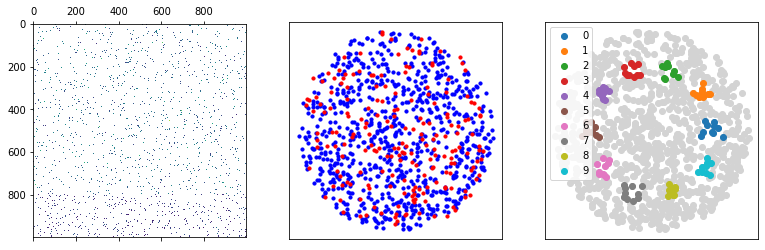

In [5]:
# X, Y, W, D = spatial.create_weights(params, rng)
f = np.load('largeB.npz')
X, Y, W, D = f['X']*meter, f['Y']*meter, f['W'], f['D']
Xstim, Ystim = spatial.create_stimulus_locations(params)

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs[0].matshow(W)
axs[1].scatter(X[:params['N_exc']], Y[:params['N_exc']], s=10, c='b')
axs[1].scatter(X[params['N_exc']:], Y[params['N_exc']:], s=10, c='r')

idx = spatial.get_stimulated(X, Y, Xstim, Ystim, params)
axs[2].scatter(X, Y, c='lightgrey')
for i, row in enumerate(idx):
    axs[2].scatter(X[row], Y[row], label=i)
axs[2].legend()

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

In [6]:
def raster(net):
    fig, ax = plt.subplots(figsize=(20,5))
    offset = 0
    ticks, mticks, labels = [], [], []
    for k in ['Exc', 'Inh']:
        plt.plot(net[f'SpikeMon_{k}'].t/second, net[f'SpikeMon_{k}'].i + offset, ',k')
        ticks.append(offset)
        mticks.append(offset+net[k].N/2)
        labels.append(k)
        offset += net[k].N
        print(k, len(net[f'SpikeMon_{k}'].i)/net.t/net[k].N)
    ticks.append(offset)
    ax.set_yticks(ticks)
    ax.set_yticks(mticks, minor=True)
    ax.set_yticklabels(labels, minor=True)
    ax.set_xlabel('seconds')
    return ax

In [7]:
def get_episode_spikes(Net, params, episode=0, sorted=True):
    offset = 0
    T, I = [], []
    episode_duration = params['ISI']*params['sequence_length']*params['sequence_count']
    full_episode_duration = params['settling_period'] + episode_duration
    t0 = episode * full_episode_duration + params['settling_period']
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SpikeMon_{k}'].t, Net[f'SpikeMon_{k}'].i + offset
        offset += Net[k].N
        mask = (t > t0) & (t < t0 + episode_duration)
        T.append(t[mask])
        I.append(i[mask])
    T = np.concatenate(T) - t0
    I = np.concatenate(I)
    if sorted:
        sorted = np.argsort(T)
        T, I = T[sorted], I[sorted]
    return I, T

In [8]:
device.reinit()
device.activate()

Net = model.create_network(X, Y, Xstim, Ystim, W, D, params, reset_dt=params['settling_period'] + params['ISI']*params['sequence_length'])
T = 0*second
for i in range(params['N_stimuli']):
    T = inputs.set_input_sequence(Net, [i]*params['sequence_length'], params, offset=T)
Net.run(T)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


Exc 290.1875 mHz
Inh 0.37383333 Hz


<AxesSubplot:xlabel='seconds'>

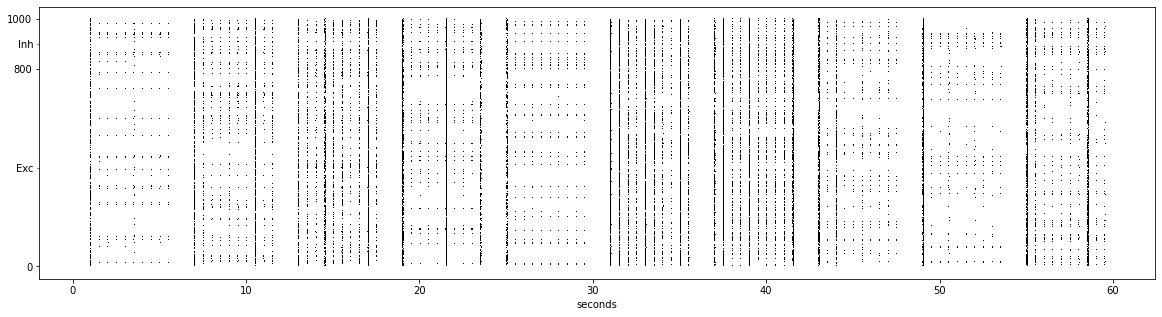

In [9]:
raster(Net)

In [10]:
single_pulse_params = {**params, 'sequence_count': 1}
spike_i, spike_t = [0]*params['N_stimuli'], [0]*params['N_stimuli']
for i in range(params['N_stimuli']):
    spike_i[i], spike_t[i] = get_episode_spikes(Net, single_pulse_params, i)

In [11]:
spike_n = np.zeros((params['N_stimuli'], params['N']), dtype=int)
for i in range(params['N_stimuli']):
    np.add.at(spike_n[i], spike_i[i], 1)
spike_n.sum(axis=1)

array([ 651, 1555, 2301, 2124,  824, 3397, 3113, 1318, 1036, 2096])

In [12]:
Cx = np.arange(params['N_stimuli'])
Cx[A] = Cx[B] = -1
Cx = Cx[Cx>=0]

In [13]:
# Classes of interest are: [A], [B], [A,B], [A,Cx], [B,Cx], [A,B,Cx]. Ignored: [Cx], []
classified_neurons = {}
for a in [True, False]:
    for b in [True, False]:
        for cx in [True, False]:
            value = np.flatnonzero(
                ((spike_n[A]>0) == a)
                & ((spike_n[B]>0) == b)
                & ((spike_n[Cx].sum(axis=0)>0) == cx)
            )
            key = ''.join([char for char, present in zip(['A','B','Cx'], [a,b,cx]) if present])
            classified_neurons[key] = value

In [14]:
classified_neurons

{'ABCx': array([  2,   7,   9,  10,  11,  14,  15,  19,  22,  24,  32,  35,  36,
         38,  39,  41,  43,  44,  46,  54,  55,  57,  64,  70,  81,  82,
         87,  93,  95, 105, 112, 118, 123, 130, 136, 137, 145, 149, 153,
        154, 155, 163, 167, 171, 173, 178, 192, 193, 203, 206, 210, 213,
        214, 217, 230, 234, 235, 247, 249, 253, 258, 264, 267, 268, 271,
        276, 279, 283, 284, 290, 294, 296, 300, 301, 307, 312, 313, 318,
        319, 320, 322, 326, 327, 332, 336, 338, 354, 359, 361, 365, 366,
        371, 376, 378, 380, 382, 384, 390, 395, 396, 397, 400, 401, 404,
        409, 411, 422, 423, 424, 442, 445, 448, 449, 457, 459, 469, 480,
        485, 496, 501, 503, 508, 510, 511, 518, 520, 521, 523, 524, 528,
        534, 538, 540, 542, 548, 550, 551, 553, 567, 572, 577, 579, 580,
        585, 588, 589, 590, 595, 597, 600, 602, 604, 608, 613, 617, 623,
        627, 629, 634, 640, 646, 650, 655, 656, 662, 663, 665, 666, 680,
        684, 685, 686, 689, 691, 694, 697, 

In [15]:
device.reinit()
device.activate()

probe = {**params, 'sequence_length': 50, 'sequence_count': 1}
Net = model.create_network(X, Y, Xstim, Ystim, W, D, probe, reset_dt=probe['settling_period'] + probe['ISI']*probe['sequence_length'])
T = 0*second
for i in range(probe['N_stimuli']):
    T = inputs.set_input_sequence(Net, [i]*probe['sequence_length'], probe, offset=T)
Net.run(T)

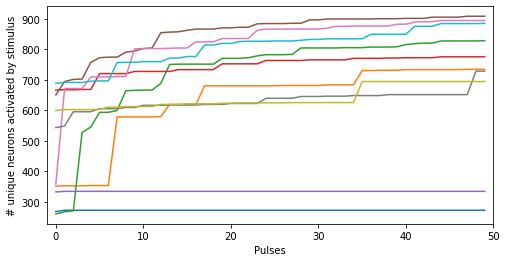

In [16]:
plt.figure(figsize=(8,4))
max_pulse = 0
for i in range(probe['N_stimuli']):
    spike_i, spike_t = get_episode_spikes(Net, probe, i)
    active_i = np.zeros(probe['N'], int)
    num_active = []
    for pulse_i, pulse_t in iterspikes(spike_i, spike_t, probe['sequence_length'], probe['ISI']):
        np.add.at(active_i, pulse_i, 1)
        num_active.append(np.sum(active_i>0))
    plt.plot(num_active)
    max_pulse = max(max_pulse, np.flatnonzero(np.diff(num_active) > 0)[-1]+1)
plt.ylabel('# unique neurons activated by stimulus')
plt.xlabel('Pulses')
plt.xlim(-1, max_pulse+1);

In [24]:
probe = {**params, 'sequence_length': params['sequence_length']-1, 'sequence_count': 1}
A, B = 0, 2
Cx = np.arange(probe['N_stimuli'])
Cx[A] = Cx[B] = -1
Cx = Cx[Cx>=0]
found_robust = False
best_so_far_val = 0
while not found_robust:
    device.reinit()
    device.activate()

    X, Y, W, D = spatial.create_weights(probe, rng)
    Xstim, Ystim = spatial.create_stimulus_locations(probe)

    Net = model.create_network(X, Y, Xstim, Ystim, W, D, probe, reset_dt=probe['settling_period'] + probe['ISI']*probe['sequence_length'])
    T = 0*second
    for i in range(probe['N_stimuli']):
        T = inputs.set_input_sequence(Net, [i]*probe['sequence_length'], probe, offset=T)
    Net.run(T)

    spike_i, spike_t = [0]*probe['N_stimuli'], [0]*probe['N_stimuli']
    for i in range(probe['N_stimuli']):
        spike_i[i], spike_t[i] = get_episode_spikes(Net, probe, i)
    
    spike_n = np.zeros((probe['N_stimuli'], probe['N']), dtype=int)
    for i in range(probe['N_stimuli']):
        np.add.at(spike_n[i], spike_i[i], 1)
    
    for a in [True, False]:
        for b in [True, False]:
            for cx in [True, False]:
                value = np.flatnonzero(
                    ((spike_n[A]>0) == a)
                    & ((spike_n[B]>0) == b)
                    & ((spike_n[Cx].sum(axis=0)>0) == cx)
                )
                key = ''.join([char for char, present in zip(['A','B','Cx'], [a,b,cx]) if present])
                classified_neurons[key] = value
    overlap_size = {key: len(value) for key, value in classified_neurons.items()}
    found_robust = all([value>=10 for key, value in overlap_size.items() if key not in ('Cx', '')])

    val = overlap_size['A']*overlap_size['B']*overlap_size['AB']
    if val > best_so_far_val:
        best_so_far = (X, Y, W, D)
        best_so_far_val = val
        mark = '*'
    else:
        mark = ''
    
    print(overlap_size, mark)

{'ABCx': 632, 'AB': 1, 'ACx': 133, 'A': 6, 'BCx': 64, 'B': 2, 'Cx': 134, '': 28} *
{'ABCx': 629, 'AB': 1, 'ACx': 110, 'A': 1, 'BCx': 104, 'B': 2, 'Cx': 136, '': 17} 
{'ABCx': 779, 'AB': 2, 'ACx': 76, 'A': 3, 'BCx': 67, 'B': 3, 'Cx': 53, '': 17} *
{'ABCx': 682, 'AB': 2, 'ACx': 104, 'A': 4, 'BCx': 88, 'B': 2, 'Cx': 88, '': 30} 
{'ABCx': 747, 'AB': 1, 'ACx': 60, 'A': 1, 'BCx': 104, 'B': 3, 'Cx': 66, '': 18} 
{'ABCx': 7, 'AB': 0, 'ACx': 27, 'A': 0, 'BCx': 433, 'B': 0, 'Cx': 510, '': 23} 
{'ABCx': 93, 'AB': 0, 'ACx': 26, 'A': 1, 'BCx': 558, 'B': 1, 'Cx': 290, '': 31} 
{'ABCx': 571, 'AB': 1, 'ACx': 41, 'A': 4, 'BCx': 223, 'B': 2, 'Cx': 130, '': 28} 
{'ABCx': 656, 'AB': 2, 'ACx': 149, 'A': 9, 'BCx': 72, 'B': 4, 'Cx': 81, '': 27} *
{'ABCx': 603, 'AB': 0, 'ACx': 101, 'A': 1, 'BCx': 178, 'B': 3, 'Cx': 103, '': 11} 
{'ABCx': 316, 'AB': 0, 'ACx': 358, 'A': 2, 'BCx': 35, 'B': 0, 'Cx': 258, '': 31} 
{'ABCx': 560, 'AB': 8, 'ACx': 163, 'A': 11, 'BCx': 121, 'B': 13, 'Cx': 98, '': 26} *
{'ABCx': 657, 'A

In [26]:
print(best_so_far_val)
# X, Y, W, D = best_so_far

2660


In [32]:
fname = 'overlap.npz'
np.savez(fname, W=W, X=X, Y=Y, D=D)
print(f'Saved structure to {fname}')

Saved structure to overlap.npz


In [33]:
device.reinit()
device.activate()

probe = {**params, 'sequence_length': 50, 'sequence_count': 1}
Net = model.create_network(X, Y, Xstim, Ystim, W, D, probe, reset_dt=probe['settling_period'] + probe['ISI']*probe['sequence_length'])
T = 0*second
for i in range(probe['N_stimuli']):
    T = inputs.set_input_sequence(Net, [i]*probe['sequence_length'], probe, offset=T)
Net.run(T)

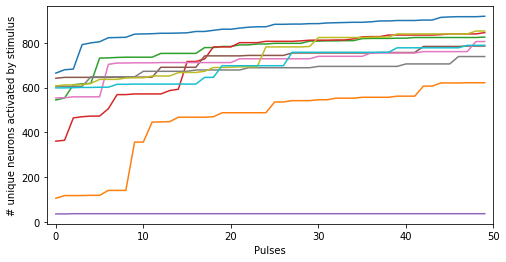

In [34]:
plt.figure(figsize=(8,4))
max_pulse = 0
for i in range(probe['N_stimuli']):
    spike_i, spike_t = get_episode_spikes(Net, probe, i)
    active_i = np.zeros(probe['N'], int)
    num_active = []
    for pulse_i, pulse_t in iterspikes(spike_i, spike_t, probe['sequence_length'], probe['ISI']):
        np.add.at(active_i, pulse_i, 1)
        num_active.append(np.sum(active_i>0))
    plt.plot(num_active)
    nzdiff = np.flatnonzero(np.diff(num_active) > 0)
    if nzdiff.size:
        max_pulse = max(max_pulse, nzdiff[-1]+1)
plt.ylabel('# unique neurons activated by stimulus')
plt.xlabel('Pulses')
plt.xlim(-1, max_pulse+1);